In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from findiff import FinDiff
import pysptools.spectro as spectro
from IPython.display import display 

scalers = [
    'wo_norm',
    'minmax',
    'standard'
]

scalers_funct = {
    'wo_norm': ['-1' for _ in range(5)],
    'minmax': [MinMaxScaler() for _ in range(5)],
    'standard': [StandardScaler() for _ in range(5)]
}

satellites = [
#     'landsat_simulated',
#     'landsat_simulated_indices',
#     'sentinel2_simulated',
#     'sentinel2_simulated_indices',
#     'sentinel2',
#     'sentinel2_indices',
#     'sentinel2_veggi',
#     'sentinel2_veggi_indices'
#     'desis_simulated',
#     'vis_nir'
    'sentinel_soil'
]

satellites_with_indices = [
    'landsat_simulated_indices',
    'sentinel2_simulated_indices',
    'sentinel2_indices',
    'sentinel2_veggi_indices'
]

soil_properties = [
    'pH',
    'OM',
    'Ca',
    'Mg',
    'K',
    'Na'
]

indices_ = [
    'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI',
    'NDMI', 'MSI', 'GCI', 'NDSI', 'BSI',
    'NDWI', 'ARVI', 'SIPI',
    'NBR', 'NDGI'
]

thresholds_path = '../data/processed_raw/soil_cane_vis_NIRS/soil_properties_thresholds.csv'

In [2]:
def check_path(path):
    files = path.split('/')
    tmp_path = ''
    
    for file in files:
        tmp_path += f"{file}/"
        if not os.path.exists(tmp_path):
            os.mkdir(tmp_path)
#         else:
#             print(f'File: **{file}** exists')

            
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [3]:

for satellite in satellites:  
    print(f"satellite: {satellite}")
    
    # Loading data
    #####################################################################

    soil_nir_data = pd.read_csv(
        f'../data/interim_raw/{satellite}/satellite_{satellite}.csv',
        sep = ";"
    )
    thresholds = pd.read_csv(thresholds_path, sep = ";")

    # Filterin data
    #####################################################################
    
    if satellite in satellites_with_indices:
        non_spectral_columns = list(set(soil_properties)| set(indices_))
    else:
        non_spectral_columns = soil_properties

    for scaler in scalers:     
#         print(f"scaler: {scaler}")
        
        df_soil_properties = soil_nir_data[soil_properties].copy()
        spectral_data = soil_nir_data.drop(non_spectral_columns, axis=1).copy()
        spectral_data_array = np.asarray(spectral_data)
        
        temp_cols = [i.split('_')[-1] for i in spectral_data.columns]
        print(temp_cols)
        spectral_data_cols = list(map(float, temp_cols))

        # Transforming data
        #####################################################################
        
        d1_dx_array = (
            np.diff(spectral_data_array[0]) / np.diff(spectral_data_cols)
        ).reshape(1,-1)

        d2_dx_array = (
            np.diff(d1_dx_array[0]) / np.diff(spectral_data_cols[:-1])
        ).reshape(1,-1)

        fft_array = np.fft.fft(spectral_data_array[0]).reshape(1,-1)

        continuum_removal_array = np.array(
            spectro.convex_hull_removal(
                1.5 - spectral_data_array[0],
                spectral_data_cols
            )[0]
        ).reshape(1,-1)

        for spectrum in spectral_data_array[1:]:
            d1x_ = (
                np.diff(spectrum) / np.diff(spectral_data_cols)
            ).reshape(1,-1)
            
            d2x_ = (
                np.diff(d1x_[0]) / np.diff(spectral_data_cols[:-1])
            ).reshape(1,-1)
            
            fft_ = np.fft.fft(spectrum).reshape(1,-1)
            
            continuum_removal_ = np.array(
                spectro.convex_hull_removal(
                    1.5 - spectrum, spectral_data_cols
                )[0]
            ).reshape(1,-1)

            d1_dx_array = np.append(d1_dx_array, d1x_, axis=0)
            d2_dx_array = np.append(d2_dx_array, d2x_, axis=0)
            fft_array = np.append(fft_array, fft_, axis=0)
            continuum_removal_array = np.append(
                continuum_removal_array, continuum_removal_, axis=0
            )

        # Normalizing data
        #####################################################################

        spectrum_scaler = scalers_funct[scaler][0]
        d1x_scaler = scalers_funct[scaler][1]
        d2_scaler = scalers_funct[scaler][2]
        continuum_removal_scaler = scalers_funct[scaler][3]

        if spectrum_scaler != '-1':
            spectrum_scaler.fit(spectral_data_array)
            d1x_scaler.fit(d1_dx_array)
            d2_scaler.fit(d2_dx_array)
            continuum_removal_scaler.fit(continuum_removal_array)

            spectral_data_array_scale = spectrum_scaler.transform(spectral_data_array)
            d1_dx_array_scale = d1x_scaler.transform(d1_dx_array)
            d2_dx_array_scale = d2_scaler.transform(d2_dx_array)
            continuum_removal_scale = continuum_removal_scaler.transform(continuum_removal_array)
            fft_array_scale = (np.absolute(fft_array)/int(fft_array.shape[1]))
        else:
            spectral_data_array_scale = spectral_data_array.copy()
            d1_dx_array_scale = d1_dx_array.copy()
            d2_dx_array_scale = d2_dx_array.copy()
            continuum_removal_scale = continuum_removal_array.copy()
            fft_array_scale = fft_array.astype(float).copy()

#         Joining all transform data
#         ####################################################################

        all_data_columns = []
        transformations = ['scE_', 'd1_', 'd2_', 'fft_', 'cr_']

        for trans_ in transformations:
            for col in spectral_data_cols:
                if ((trans_ == 'd1_' and col in [spectral_data_cols[-1]]) or
                    (trans_ == 'd2_' and col in spectral_data_cols[-2:])):
                    continue
                all_data_columns.append(f'{trans_}{col}')

        all_data = np.concatenate(
            (
                spectral_data_array_scale, 
                d1_dx_array_scale, 
                d2_dx_array_scale, 
                fft_array_scale,
                continuum_removal_scale
            ), axis=1
        )

        all_data_final = pd.DataFrame(
            data=all_data,
            columns=all_data_columns
        )

        # Creating CSV file with all the features of the used_propeties
        #####################################################################

        properties_scaler = scalers_funct[scaler][4]
        
        # Choose properties
        soil_properties_ = [
            'pH',
            'OM',
            'Ca',
            'Mg',
            'K',
            'Na'
        ]
        
        for property_ in soil_properties_:
            
            temp_all_data = all_data_final.copy()
            comp_values = list(df_soil_properties[property_])

            comp_labels = []
            comp_thresholds = thresholds[thresholds['compuesto'] == property_]

            for comp_vi in comp_values:   
                for index, row in comp_thresholds.iterrows():
                    if (comp_vi > row['lim_inf']) and (comp_vi <= row['lim_sup']):
                        comp_labels.append(row['etiqueta'])


            comp_values_ = np.array(comp_values).reshape(-1,1)
            
            if properties_scaler != '-1':
                properties_scaler.fit(comp_values_)
                comp_values_scale = properties_scaler.transform(comp_values_)
            else:
                comp_values_scale = comp_values_.copy()

            comp_values_ = comp_values_.flatten()
            comp_values_scale = comp_values_scale.flatten()

            ids = list(range(0, len(comp_values_)))

            for col_ in indices_:
                if col_ in soil_nir_data.columns:
                    temp_all_data.insert(0, col_, soil_nir_data[col_])

            temp_all_data.insert (0, f'sc_{property_}', comp_values_scale)
            temp_all_data.insert (0, property_, comp_values_)
            temp_all_data.insert (0, f'Et_{property_}', comp_labels)
            temp_all_data.insert (0, 'ID', ids)
            
#             display(temp_all_data.head())
            
            check_path(f'../data/models/input/{satellite}/{scaler}/')
            temp_all_data.to_csv(
                f'../data/models/input/{satellite}/{scaler}/' +
                f"All_{scaler}_d1d2_fft_feature_{property_}_.csv",
                sep = ';',
                decimal = '.',
                index=False
            )


satellite: sentinel_soil
['442.3', '492.1', '559.0', '665.0', '703.8', '739.1', '779.7', '833.0', '864.0', '943.2', '1610.4', '2202.4']
['442.3', '492.1', '559.0', '665.0', '703.8', '739.1', '779.7', '833.0', '864.0', '943.2', '1610.4', '2202.4']


<ipython-input-3-c510481b9a64>:100: ComplexWarning: Casting complex values to real discards the imaginary part
  fft_array_scale = fft_array.astype(float).copy()


['442.3', '492.1', '559.0', '665.0', '703.8', '739.1', '779.7', '833.0', '864.0', '943.2', '1610.4', '2202.4']


### Pruebas derivada numérica

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

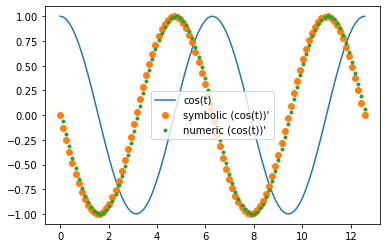

In [9]:
t = np.linspace(0, 4*np.pi, 100)
y = np.cos(t) # Función original
kdy = -np.sin(t) # Derivada simbólica
dy = np.diff(y)/np.diff(t) # Derivada numérica

plt.plot(t, y, '-', label='cos(t)')
plt.plot(t, kdy, 'o', label='symbolic (cos(t))\'')
plt.plot(t[1:], dy, '.', label='numeric (cos(t))\' ')
 
plt.legend()
plt.show()

In [10]:
path_soil_data = os.path.abspath(f'../data/nirs/soil_cane_vis-NIR.csv')
soil_nir_data = pd.read_csv(path_soil_data, sep = ";")

In [11]:
print(soil_nir_data.shape)
soil_nir_data[soil_nir_data.columns].head()

(653, 257)


Sand  Clay  Silt  pH_3Cat    pH         OM        Ca        Mg         K  \
0  18.4  41.2  40.4     4.70  4.70   3.011138  0.481978  0.213796  0.171674   
1  68.4  15.2  16.4     5.00  5.00  12.271341  1.287727  0.418722  0.421729   
2  28.4  37.2  34.4     5.07  5.07   5.326189  3.592768  0.533857  0.213425   
3  32.4  35.2  32.4     4.55  4.55   7.198116  1.198907  0.452394  0.428312   
4  20.4  35.2  44.4     4.44  4.44   4.643188  2.353349  0.526435  0.336426   

         Na  ...    2414.5      2423    2431.5      2440    2448.5      2457  \
0  0.146597  ...  0.371383  0.378890  0.386586  0.392239  0.395681  0.398774   
1  0.201236  ...  0.502976  0.510954  0.519375  0.526996  0.533605  0.540453   
2  0.176261  ...  0.348180  0.354749  0.361053  0.365611  0.368472  0.371119   
3  0.220661  ...  0.523816  0.531462  0.538671  0.543519  0.547046  0.550635   
4  0.173677  ...  0.342146  0.348621  0.354735  0.359123  0.362023  0.364714   

     2465.5      2474    2482.5      2491  
0  0.402525  0.406814  0.411534  0.414343  
1  0.547456  0.554312  0.560825  0.565450  
2  0.373985  0.377056  0.380232  0.382145  
3  0.554689  0.558928  0.563029  0.565520  
4  0.367813  0.370938  0.374218  0.376289  

[5 rows x 257 columns]

In [12]:
diff_step = 8.5
print(diff_step)
d1_dx = FinDiff(0, diff_step, 1, acc = 10)
d2_dx = FinDiff(0, diff_step, 2, acc = 10)

8.5


In [14]:
n = 50
t = np.arange(8.5, 8.5*(n+1), 8.5)
y = soil_nir_data.iloc[:n, 10]
print(len(t), ' ', len(y))

50   50


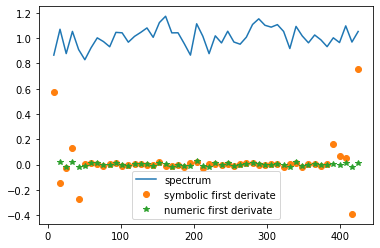

In [15]:
dy1 = d1_dx(y)
dy1_ = (np.diff(y)/np.diff(t))

plt.plot(t, y, '-', label='spectrum')
plt.plot(t, dy1, 'o', label='symbolic first derivate')
plt.plot(t[1:], dy1_, '*', label='numeric first derivate')
 
plt.legend()
plt.show()

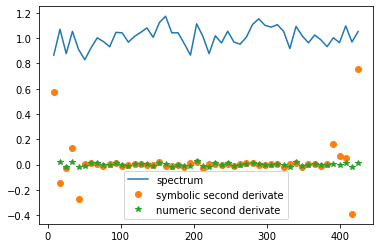

In [16]:
dy2 = d2_dx(dy1)
dx_2_ = (np.diff(dy1_)/np.diff(t[1:]))

plt.plot(t, y, '-', label='spectrum')
plt.plot(t, dy1, 'o', label='symbolic second derivate')
plt.plot(t[1:], dy1_, '*', label='numeric second derivate')
 
plt.legend()
plt.show()